# Project 4
## Ridge & Lasso Calculation of Cold Wave Final dataset with GridSearchCV
## Finding the Best Model

---
### Import Libraries

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Imports for Modeling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Imports for Evaluation
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error 

from warnings import filterwarnings
filterwarnings('ignore')


### Read in Data

In [2]:
cold_final = pd.read_csv('../data/cold_final_dataset.csv')
cold_final.head()

,Unnamed: 0,country,subregion,region,location,temperature,start_year,start_month,total_deaths,start_date,end_date,duration_days,duration,latitude,longitude,delta_temp_C,delta_temp_std
0,0,Afghanistan,Southern Asia,Asia,"Hirat, Faryab, Jawzjan, Balkh, Samangan, Sar-e...",-25.0,2001,1,150.0,2001-01-31,2001-02-20,20 days,20,30.0,70.0,-24.856821,-8.561158
1,1,Poland,Eastern Europe,Europe,"Dolnoslaskie, Kujawsko-Pomorskie, Lodzkie, Lub...",-25.0,2001,10,270.0,2001-10-10,2002-01-20,102 days,102,50.0,20.0,-15.941674,-4.306348
2,2,Poland,Eastern Europe,Europe,"Dolnoslaskie, Kujawsko-Pomorskie, Lodzkie, Lub...",-25.0,2001,10,270.0,2001-10-10,2002-01-20,102 days,102,50.0,20.0,-15.941674,-4.306348
3,3,Peru,Latin America and the Caribbean,Americas,"Ayacucho, Huancavelica, Tacna, Moquegua, Arequ...",-28.0,2003,7,339.0,2003-07-07,2003-08-15,39 days,39,-10.0,-70.0,-43.303703,-20.441972
4,4,South Africa,Sub-Saharan Africa,Africa,"Gauteng, Eastern Cape provinces",0.0,2007,5,22.0,2007-05-21,2007-05-27,6 days,6,-30.0,30.0,-1.690848,-0.672643


In [9]:
cold_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      41 non-null     int64  
 1   country         41 non-null     object 
 2   subregion       41 non-null     object 
 3   region          41 non-null     object 
 4   location        40 non-null     object 
 5   temperature     41 non-null     float64
 6   start_year      41 non-null     int64  
 7   start_month     41 non-null     int64  
 8   total_deaths    41 non-null     float64
 9   start_date      41 non-null     object 
 10  end_date        41 non-null     object 
 11  duration_days   41 non-null     object 
 12  duration        41 non-null     int64  
 13  latitude        41 non-null     float64
 14  longitude       41 non-null     float64
 15  delta_temp_C    41 non-null     float64
 16  delta_temp_std  41 non-null     float64
dtypes: float64(6), int64(4), object(7)
me

---
### Model Ridge and Lasso
No need to clean data.  This is a modeling notebook

In [3]:
# Created a function to run models more easily
def fit_and_evaluate_ridge_lasso(train_df, X, y, test_size=0.2, random_state=42, cv=5, alpha_range=None, plot=True):
    """
    train_df : pandas.DataFrame
        The full training frame with all columns available
    X : array-like or list of column names
        Features matrix or names; can be a DataFrame already or a list of columns to select from train_df
    y : array-like or column name
        Target vector or single column name
    
    Returns:
        models: dict of fitted GridSearchCV objects
        results: dict of evaluation metrics (R2, MAE, MSE, RMSE)
    """

    if alpha_range is None:
        alpha_range = np.logspace(-4, 4, 30)  # Default grid

    # If X and y are column names, pull them from train_df
    if isinstance(X, list) and isinstance(train_df, pd.DataFrame):
        X_data = train_df[X]
    else:
        X_data = X
    if isinstance(y, str) and isinstance(train_df, pd.DataFrame):
        y_data = train_df[y]
    else:
        y_data = y

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=test_size, random_state=random_state)

    # Ridge and Lasso Pipelines
    ridge_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", Ridge())
    ])
    lasso_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", Lasso(max_iter=10000))
    ])
    param_grid = {"regressor__alpha": alpha_range}
    ridge_gs = GridSearchCV(ridge_pipe, param_grid, cv=cv, scoring='r2')
    lasso_gs = GridSearchCV(lasso_pipe, param_grid, cv=cv, scoring='r2')

    pipelines = {"Ridge (GridSearchCV)": ridge_gs, "Lasso (GridSearchCV)": lasso_gs}
    results = {}
    models = {}

    for name, gs in pipelines.items():
        gs.fit(X_train, y_train)
        best_alpha = gs.best_params_["regressor__alpha"]
        print(f"{name} best alpha: {best_alpha:.5f}")
        
        y_train_pred = gs.predict(X_train)
        y_test_pred = gs.predict(X_test)
        # Scores and evaluation
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        cv_score = cross_val_score(gs.best_estimator_, X_train, y_train, cv=cv, scoring='r2').mean()
        print(f"{name} Training R2 Score: {train_r2:.3f}")
        print(f"{name} Test R2 Score: {test_r2:.3f}")
        print(f"{name} Cross Val Score (R2): {cv_score:.3f}")

        # Metrics
        results[name] = {
            "Best Alpha": best_alpha,
            "Train R2": train_r2,
            "Test R2": test_r2,
            "CV R2": cv_score,
            "MAE": mean_absolute_error(y_test, y_test_pred),
            "MSE": mean_squared_error(y_test, y_test_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred))
        }
        models[name] = gs

        if plot:
            plt.figure(figsize=(5,3))
            plt.scatter(y_test, y_test_pred, color='maroon', alpha=0.7, edgecolor='k')
            plt.xlabel("Actual Target")
            plt.ylabel("Predicted Target")
            plt.title(f"Actual vs Predicted - {name}")
            plt.show()

            plt.figure(figsize=(5,3))
            residuals = y_test - y_test_pred
            plt.hist(residuals, bins=30, color='maroon')
            plt.title(f"Residuals Histogram - {name}")
            plt.show()

    print("\nEvaluation metrics summary:")

    return pd.DataFrame(results)


### Model 1, Log scale is wide with alpha_range=np.logspace(-4,4,50)

Ridge (GridSearchCV) best alpha: 16.76833
Ridge (GridSearchCV) Training R2 Score: 0.674
Ridge (GridSearchCV) Test R2 Score: -1.054
Ridge (GridSearchCV) Cross Val Score (R2): 0.087


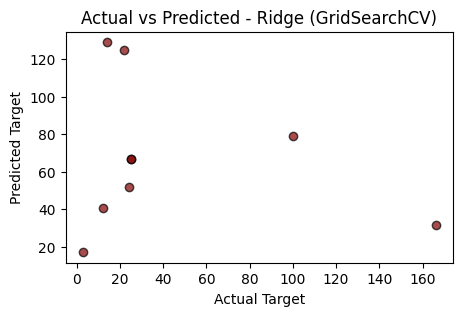

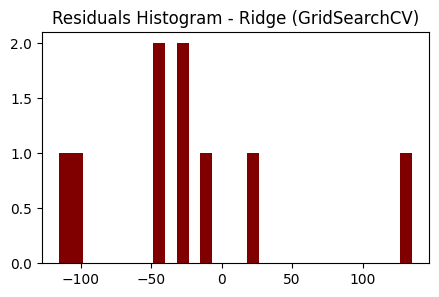

Lasso (GridSearchCV) best alpha: 24.42053
Lasso (GridSearchCV) Training R2 Score: 0.582
Lasso (GridSearchCV) Test R2 Score: -0.810
Lasso (GridSearchCV) Cross Val Score (R2): 0.300


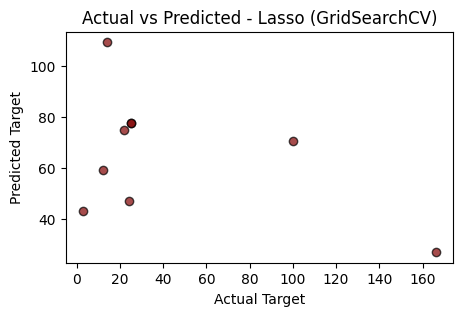

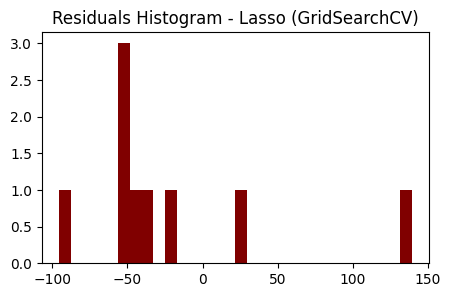


Evaluation metrics summary:


,Ridge (GridSearchCV),Lasso (GridSearchCV)
Best Alpha,16.768329,24.420531
Train R2,0.673952,0.582135
Test R2,-1.054009,-0.810254
CV R2,0.087049,0.300432
MAE,58.678252,59.182412
MSE,5301.220440,4672.108048
RMSE,72.809480,68.352820


In [15]:
# Set up features and target
features = ['temperature', 'start_year', 'start_month', 'duration', 'latitude', 'longitude', 'delta_temp_C', 'delta_temp_std']
X = cold_final[features]
y = cold_final['total_deaths']
fit_and_evaluate_ridge_lasso(cold_final, X, y, alpha_range=np.logspace(-4,4,50))

#### Doesn't look like very good model?
### Model 2: Try with new features, same alpha range

Ridge (GridSearchCV) best alpha: 16.76833
Ridge (GridSearchCV) Training R2 Score: 0.674
Ridge (GridSearchCV) Test R2 Score: -1.054
Ridge (GridSearchCV) Cross Val Score (R2): 0.087


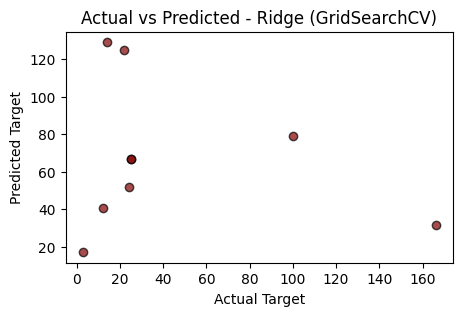

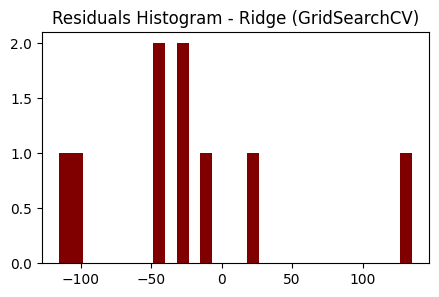

Lasso (GridSearchCV) best alpha: 24.42053
Lasso (GridSearchCV) Training R2 Score: 0.582
Lasso (GridSearchCV) Test R2 Score: -0.810
Lasso (GridSearchCV) Cross Val Score (R2): 0.300


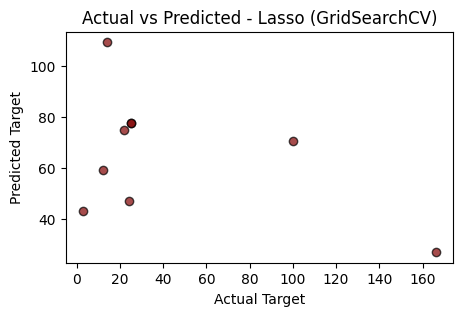

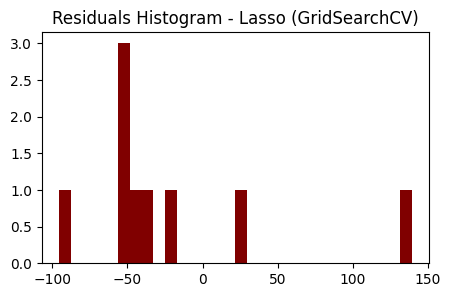


Evaluation metrics summary:


,Ridge (GridSearchCV),Lasso (GridSearchCV)
Best Alpha,16.768329,24.420531
Train R2,0.673952,0.582135
Test R2,-1.054009,-0.810254
CV R2,0.087049,0.300432
MAE,58.678252,59.182412
MSE,5301.220440,4672.108048
RMSE,72.809480,68.352820


Ridge (GridSearchCV) best alpha: 0.01931
Ridge (GridSearchCV) Training R2 Score: 0.786
Ridge (GridSearchCV) Test R2 Score: -8.735
Ridge (GridSearchCV) Cross Val Score (R2): 0.042


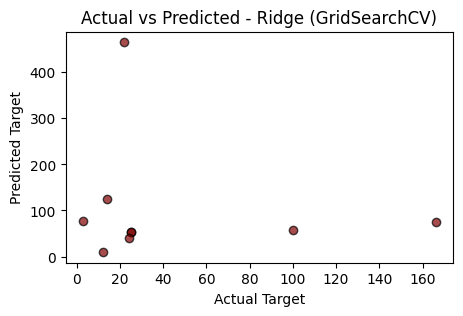

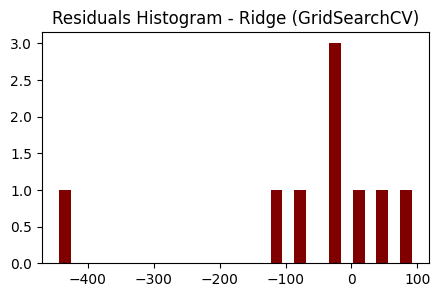

Lasso (GridSearchCV) best alpha: 24.42053
Lasso (GridSearchCV) Training R2 Score: 0.550
Lasso (GridSearchCV) Test R2 Score: -0.431
Lasso (GridSearchCV) Cross Val Score (R2): 0.179


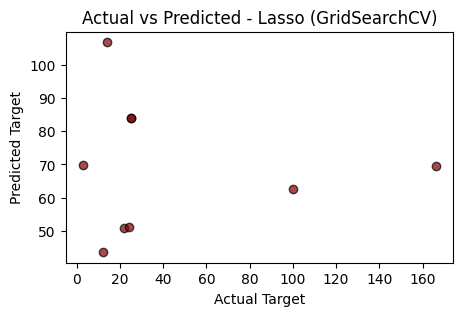

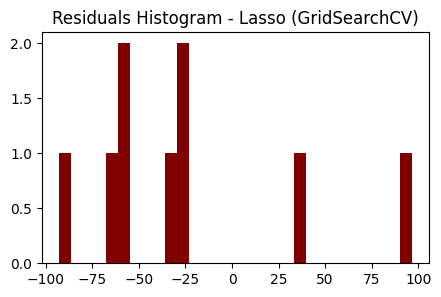


Evaluation metrics summary:


,Ridge (GridSearchCV),Lasso (GridSearchCV)
Best Alpha,0.019307,24.420531
Train R2,0.786065,0.549642
Test R2,-8.734878,-0.431328
CV R2,0.042198,0.178545
MAE,92.889807,55.392709
MSE,25124.877814,3694.132968
RMSE,158.508289,60.779379


In [6]:
# Set up features and target
features = ['temperature','duration', 'latitude', 'longitude', 'delta_temp_C', 'delta_temp_std']
X = cold_final[features]
y = cold_final['total_deaths']

fit_and_evaluate_ridge_lasso(cold_final, X, y, alpha_range=np.logspace(-4,4,50))

### Model 3: Original features, but alpha_range = np.linspace(0.01, 1, 10)
This is linear and uncommon

Ridge (GridSearchCV) best alpha: 1.00000
Ridge (GridSearchCV) Training R2 Score: 0.759
Ridge (GridSearchCV) Test R2 Score: -2.191
Ridge (GridSearchCV) Cross Val Score (R2): -0.175


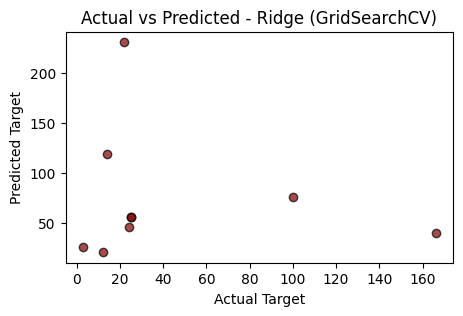

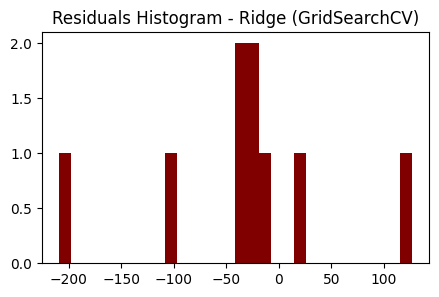

Lasso (GridSearchCV) best alpha: 0.56000
Lasso (GridSearchCV) Training R2 Score: 0.786
Lasso (GridSearchCV) Test R2 Score: -4.880
Lasso (GridSearchCV) Cross Val Score (R2): -0.222


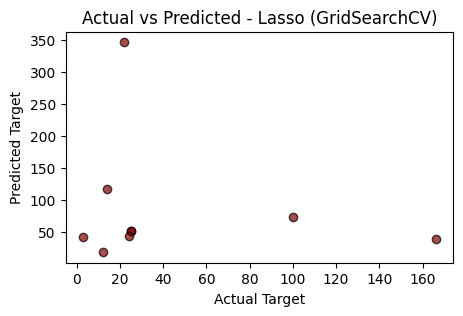

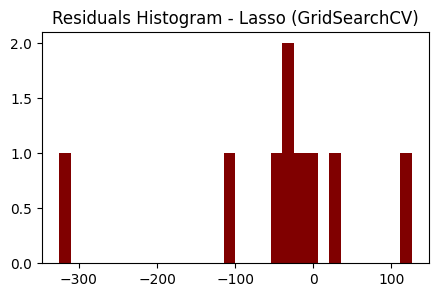


Evaluation metrics summary:


,Ridge (GridSearchCV),Lasso (GridSearchCV)
Best Alpha,1.000000,0.560000
Train R2,0.758772,0.785877
Test R2,-2.191239,-4.879693
CV R2,-0.175434,-0.222164
MAE,64.322344,78.001564
MSE,8236.311882,15174.978907
RMSE,90.754129,123.186764


In [7]:
features = ['temperature', 'start_year', 'start_month', 'duration', 'latitude', 'longitude', 'delta_temp_C', 'delta_temp_std']
X = cold_final[features]
y = cold_final['total_deaths']

fit_and_evaluate_ridge_lasso(cold_final, X, y, alpha_range=np.linspace(0.01, 1, 10))

### Model 4: Original features, but narrower Log scale: alpha_range = np.logspace(-2, 2, 10)


Ridge (GridSearchCV) best alpha: 12.91550
Ridge (GridSearchCV) Training R2 Score: 0.690
Ridge (GridSearchCV) Test R2 Score: -1.097
Ridge (GridSearchCV) Cross Val Score (R2): 0.079


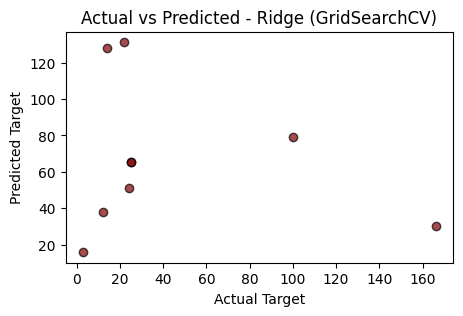

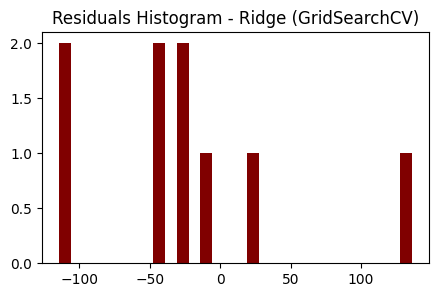

Lasso (GridSearchCV) best alpha: 35.93814
Lasso (GridSearchCV) Training R2 Score: 0.494
Lasso (GridSearchCV) Test R2 Score: -0.664
Lasso (GridSearchCV) Cross Val Score (R2): 0.217


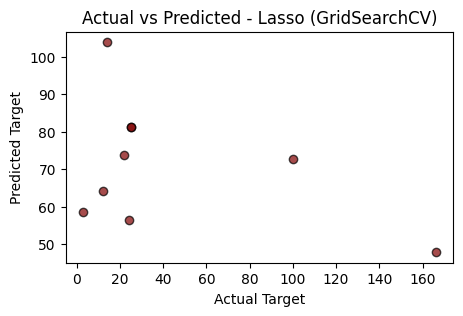

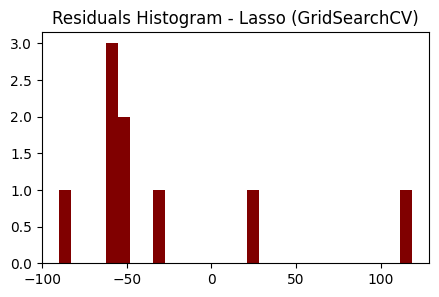


Evaluation metrics summary:


,Ridge (GridSearchCV),Lasso (GridSearchCV)
Best Alpha,12.915497,35.938137
Train R2,0.689974,0.494438
Test R2,-1.096808,-0.663700
CV R2,0.078996,0.216927
MAE,58.507640,59.973151
MSE,5411.680058,4293.865684
RMSE,73.564122,65.527595


In [8]:
features = ['temperature', 'start_year', 'start_month', 'duration', 'latitude', 'longitude', 'delta_temp_C', 'delta_temp_std']
X = cold_final[features]
y = cold_final['total_deaths']

fit_and_evaluate_ridge_lasso(cold_final, X, y, alpha_range = np.logspace(-2, 2, 10))

### Model 5, New Features, alpha_range=np.logspace(-4,4,50)

Ridge (GridSearchCV) best alpha: 11.51395
Ridge (GridSearchCV) Training R2 Score: 0.667
Ridge (GridSearchCV) Test R2 Score: -0.521
Ridge (GridSearchCV) Cross Val Score (R2): -0.057


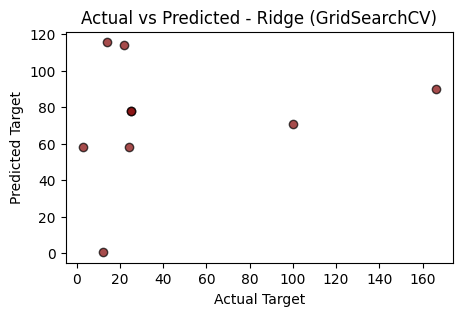

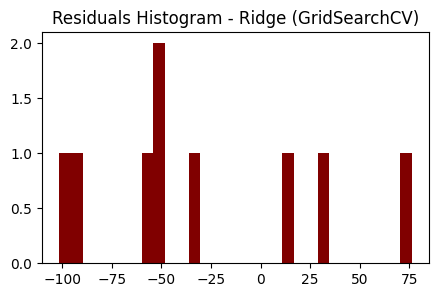

Lasso (GridSearchCV) best alpha: 35.56480
Lasso (GridSearchCV) Training R2 Score: 0.465
Lasso (GridSearchCV) Test R2 Score: -0.512
Lasso (GridSearchCV) Cross Val Score (R2): 0.161


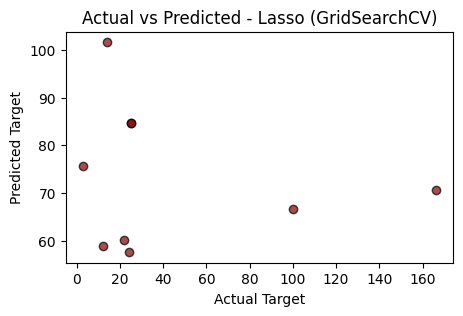

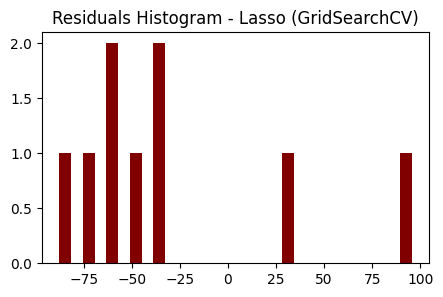


Evaluation metrics summary:


,Ridge (GridSearchCV),Lasso (GridSearchCV)
Best Alpha,11.513954,35.564803
Train R2,0.667478,0.464974
Test R2,-0.520518,-0.512324
CV R2,-0.057495,0.160650
MAE,56.125438,58.596901
MSE,3924.326148,3903.176892
RMSE,62.644442,62.475410


In [11]:
features = ['temperature', 'duration', 'latitude', 'longitude', 'delta_temp_C']
X = cold_final[features]
y = cold_final['total_deaths']

fit_and_evaluate_ridge_lasso(cold_final, X, y, alpha_range = np.logspace(-4, 4, 50))

### Model 6, Switch Delta-temp_C with Delta_temp_std

Ridge (GridSearchCV) best alpha: 11.51395
Ridge (GridSearchCV) Training R2 Score: 0.664
Ridge (GridSearchCV) Test R2 Score: -0.424
Ridge (GridSearchCV) Cross Val Score (R2): -0.074


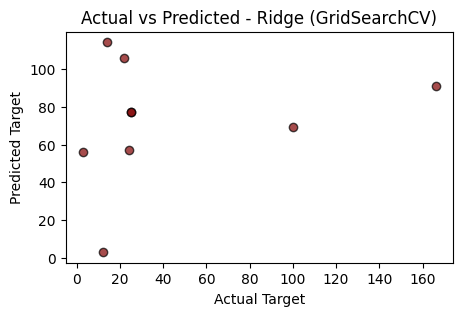

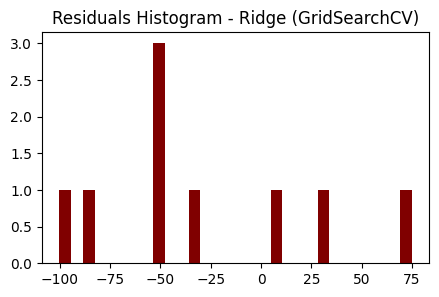

Lasso (GridSearchCV) best alpha: 24.42053
Lasso (GridSearchCV) Training R2 Score: 0.550
Lasso (GridSearchCV) Test R2 Score: -0.431
Lasso (GridSearchCV) Cross Val Score (R2): 0.179


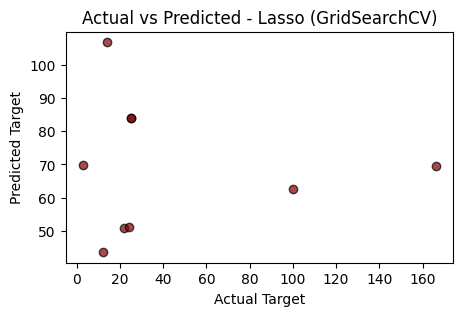

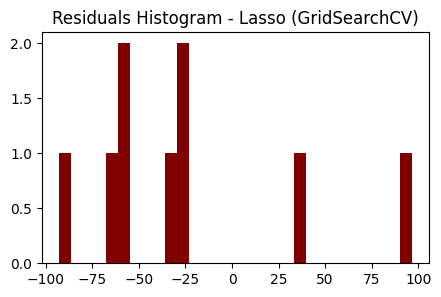


Evaluation metrics summary:


,Ridge (GridSearchCV),Lasso (GridSearchCV)
Best Alpha,11.513954,24.420531
Train R2,0.664363,0.549642
Test R2,-0.424288,-0.431328
CV R2,-0.074033,0.178545
MAE,54.346048,55.392709
MSE,3675.963356,3694.132968
RMSE,60.629723,60.779379


In [12]:
features = ['temperature', 'duration', 'latitude', 'longitude', 'delta_temp_std']
X = cold_final[features]
y = cold_final['total_deaths']

fit_and_evaluate_ridge_lasso(cold_final, X, y, alpha_range = np.logspace(-4, 4, 50))

### Model 7:  Original Features, drop delta_temp_c, alpha_range = np.logspace(-4, 4, 50)

Ridge (GridSearchCV) best alpha: 16.76833
Ridge (GridSearchCV) Training R2 Score: 0.673
Ridge (GridSearchCV) Test R2 Score: -1.072
Ridge (GridSearchCV) Cross Val Score (R2): 0.083


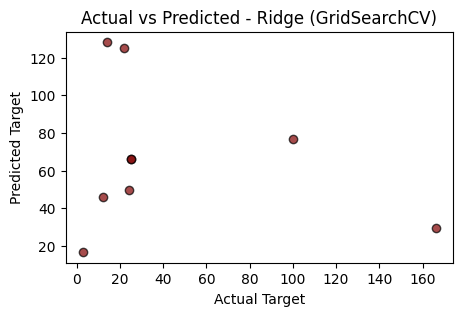

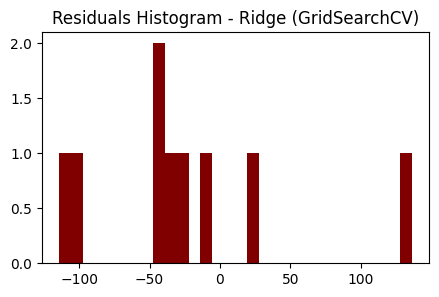

Lasso (GridSearchCV) best alpha: 24.42053
Lasso (GridSearchCV) Training R2 Score: 0.582
Lasso (GridSearchCV) Test R2 Score: -0.810
Lasso (GridSearchCV) Cross Val Score (R2): 0.300


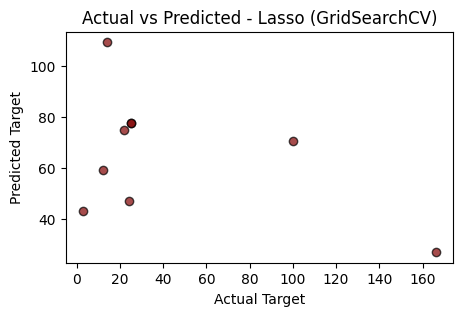

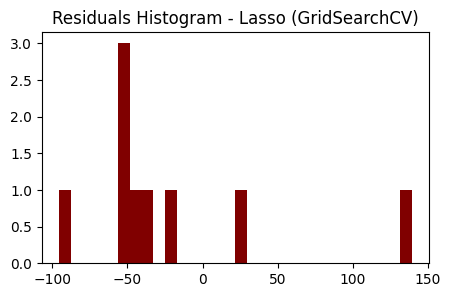


Evaluation metrics summary:


,Ridge (GridSearchCV),Lasso (GridSearchCV)
Best Alpha,16.768329,24.420531
Train R2,0.673468,0.582135
Test R2,-1.072120,-0.810254
CV R2,0.082986,0.300432
MAE,59.144841,59.182412
MSE,5347.963745,4672.108048
RMSE,73.129773,68.352820


In [13]:
features = ['temperature', 'start_year', 'start_month', 'duration', 'latitude', 'longitude', 'delta_temp_std']
X = cold_final[features]
y = cold_final['total_deaths']

fit_and_evaluate_ridge_lasso(cold_final, X, y, alpha_range=np.logspace(-4,4,50))

#### This is almost exactly the same as the 1st model with Delta_temp_C ...

### Model 8: All Features minum Delta_temp_std, alpha_range = np.logspace(-4, 4, 50)

Ridge (GridSearchCV) best alpha: 16.76833
Ridge (GridSearchCV) Training R2 Score: 0.675
Ridge (GridSearchCV) Test R2 Score: -1.151
Ridge (GridSearchCV) Cross Val Score (R2): 0.093


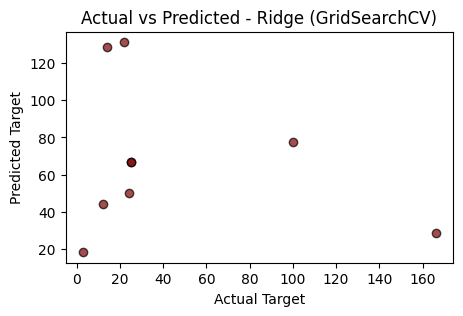

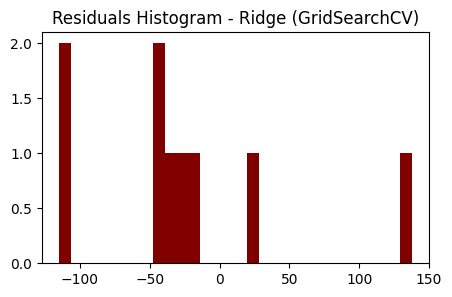

Lasso (GridSearchCV) best alpha: 24.42053
Lasso (GridSearchCV) Training R2 Score: 0.582
Lasso (GridSearchCV) Test R2 Score: -0.810
Lasso (GridSearchCV) Cross Val Score (R2): 0.299


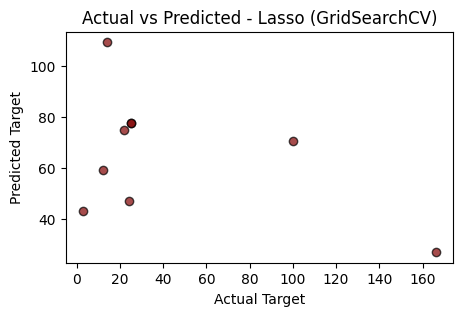

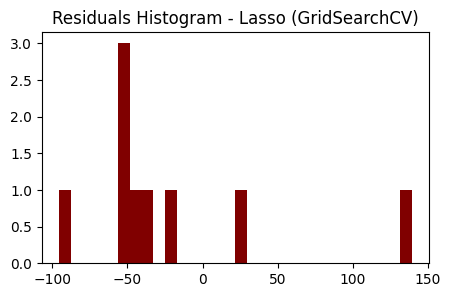


Evaluation metrics summary:


,Ridge (GridSearchCV),Lasso (GridSearchCV)
Best Alpha,16.768329,24.420531
Train R2,0.675134,0.582135
Test R2,-1.150819,-0.810254
CV R2,0.093280,0.299317
MAE,60.131806,59.182412
MSE,5551.077258,4672.108048
RMSE,74.505552,68.352820


In [14]:
features = ['temperature', 'start_year', 'start_month', 'duration', 'latitude', 'longitude', 'delta_temp_C']
X = cold_final[features]
y = cold_final['total_deaths']

fit_and_evaluate_ridge_lasso(cold_final, X, y, alpha_range=np.logspace(-4,4,50))

#### Again similar to Models 1 & 7.  Start_yr and Start Month isn't helping in creating the model.
---
## Conclusion
Comparing all the metrics and results, **Model 6** performed the best, though still dismal. Comparing Ridge and Lasso, both were similar in all metrics, except Lasso performed better in the cross-validation score at 0.17 compared to Ridge's -0.07

To test the unseen test data, we'll use Model 6: Lasso.
Features are temperature, duration, latitude, longitude, delta_temp_std.
Alpha range is log(-4,, 4, 50)
